In [4]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('data/stage1_train').glob('*/images/*.png')
# 특정 디렉토리 내에서 image폴더 내 모든 .png 파일 찾기

training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45] # 특정 경로 선택

im = imageio.imread(str(im_path)) # 이미지 로드

/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_5694/3494560462.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


### Dealing with color

In [7]:
# Print image dimensions
print('Original image shape: {}'.format(im.shape)) # 이미지 차원 출력

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
# Remove the alpha channel which is the fourth channel in the image
im_rgb = im[:, :, :3]  # Keep only the first three channels -> RGB

# Convert the RGB image to grayscale
im_gray = rgb2gray(im_rgb)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


#### 왜 채널 4개?
RGBA -> A (Alpha): 알파 채널, 이미지의 투명도를 나타냅니다. 이 값은 픽셀의 불투명도를 조절하며, 0은 완전히 투명, 255는 완전히 불투명을 의미합니다 (0에서 255까지의 범위에서 값을 가질 수 있습니다)

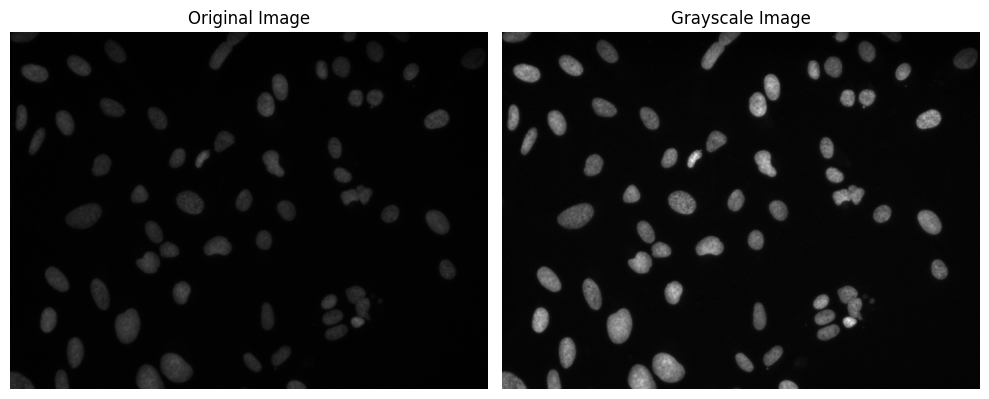

In [8]:
# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.imshow(im_rgb)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap = 'gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### Removing background
- If we find best separation value, we can 'mask out' the background data, then simply count the objects we're left with
- 'Otsu' method -> Models image as bimodal distribution and finds optimal separation value
- Bimodal distribution : 두 개의 뚜렷한 최빈값을 가진 확률 분포

In [9]:
from skimage.filters import threshold_otsu

# 회색조 이미지의 최적 임계값을 자동으로 계산
# 두 개의 클래스 : 객체와 배경으로 분할하는 최적 값
thresh_val = threshold_otsu(im_gray)

# 이진 마스크 생성 : 객체면 1, 배경이면 0
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure larger portion of the mask is considered background
# 객체가 배경보다 더 많이 차지하고 있다면, 마스크의 0과 1을 바꿈
# -> 목적에 따라 객체와 배경을 명확히 구분하기 위한 조정 과정
if np.sum(mask == 0) < np.sum(mask == 1) :
    mask = np.where(mask, 0, 1)

In [28]:
thresh_val

0.0819546568627451

In [29]:
mask
# 이미지 내 특정부분을 관심영역으로 선택함

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

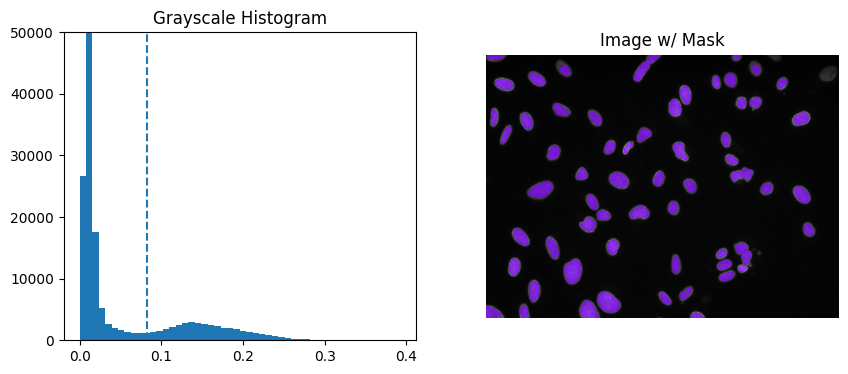

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)

# 마스크 값이 있는 곳은 유지, 없는 곳은 NaN으로 설정
# -> 마스크가 적용되지 않은 부분은 투명하게 표시
mask_for_display = np.where(mask, mask, np.nan)

# 회색조 이미지를 배경으로 표시
plt.imshow(im_gray, cmap='gray')

# 마스크를 이미지 위에 오버레이
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.7)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

### Deriving individual masks for each object
- We need to get separate mask for each nucleus
- Look for all objects in the mask that are connected, and assign each of them using ndimage.label

In [11]:
from scipy import ndimage

# 이진 마스크에서 서로 연결된 구성 요소(영역)을 식별
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1): # 각 레이블 번호 반복
    label_mask = np.where(labels == label_num, 1, 0) # 현재 레이블 번호에 해당하는 픽셀만을 1
    label_arrays.append(label_mask) # 마스크에 추가

# 식별된 구성 요소 수 출력
print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


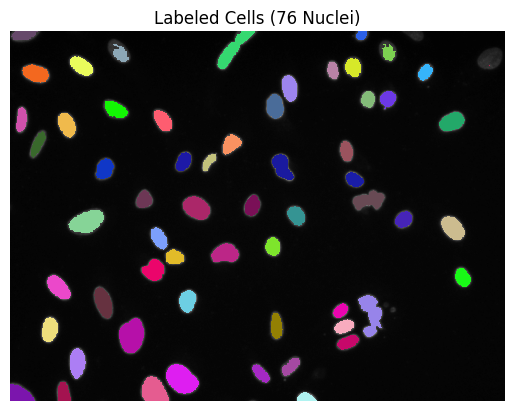

In [12]:
# Create a random colormap
from matplotlib.colors import ListedColormap

# 랜덤 컬러맵 생성
rand_cmap = ListedColormap(np.random.rand(256,3))

# 레이블 데이터 준비 : 레이블된 값들은 레이블로 유지, 아니면 background 투명 처리
labels_for_display = np.where(labels > 0, labels, np.nan)

# 이미지 시각화
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap) # 마스크 색 구분
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

#### 2 Probs
- Pixels that stand alone(top right) -> 레이블 안됨
- Combined into a single mask(top middle)

In [13]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords] # 각 객체 찾아서 부분 추출
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        
        # 객체가 너무 작은 경우, 해당 레이블의 모든 위치를 0으로 설정하여 마스크에서 제거
        mask = np.where(labels == label_ind+1, 0, mask)
    
# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} seperate components / objects detected.'.format(nlabels))
# 16개 제거됨

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 seperate components / objects detected.


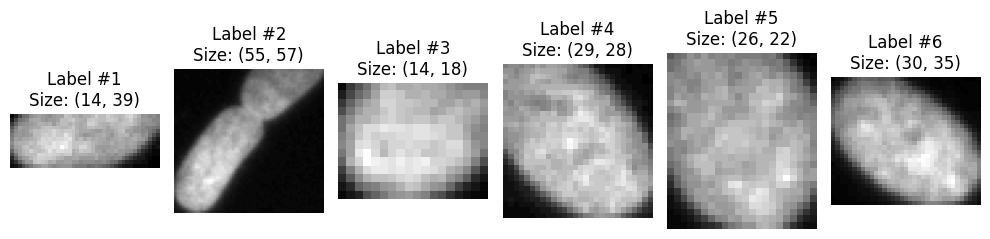

In [14]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2 : Adjacent cell prob
-> two cells considered part of same object
-> Mask erosion : We shrink the mask to open up differences between the cells

In [16]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1] # 해당 문제 셀

cell_mask = mask[two_cell_indices] # 그것의 마스크

# 이진 오프닝 수행
# 침식(erosio) -> 팽창(dilation) 8번 반복
# 객체의 경계가 더 부드러워지고, 작은 객체나 잡음이 효과
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations = 8)

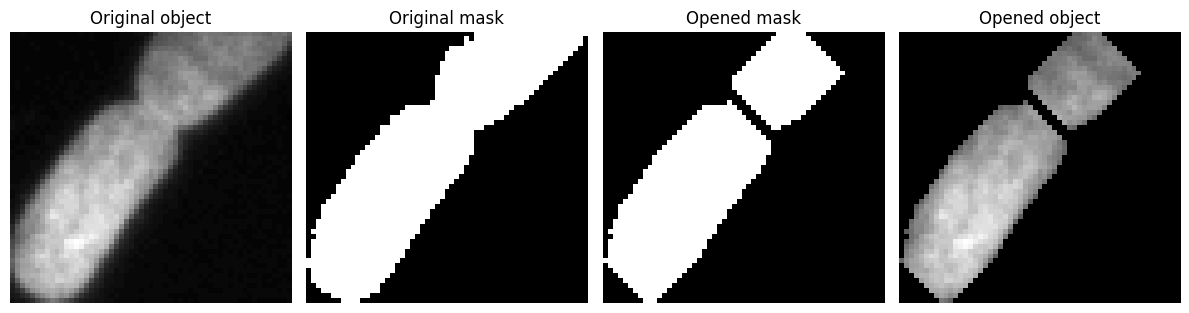

In [17]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')

axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')

axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')

axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convert each labeled object to Run Line Encoding
- Walk through array -> Find pixels that is part of the mask -> Index and count how many

In [19]:
def rle_encoding(x) :
    '''
    x : numpy array of shape(height, width), 1-mask, 0-background
    returns run length as list
    '''
    
    dots = np.where(x.T.flatten()==1)[0] 
    # .T sets Fortran or der down-then-right
    # .flatten() : 배열 1차원 변환
    # 마스크가 적용된 픽셀 위치 찾기
    
    run_lengths = []
    prev = -2
    
    # 반복문에서 각 픽셀 위치 b에 대해 검사하여 이전 픽셀과의 연속성 확인
    for b in dots:
        # 현재 픽셀이 이전 픽셀의 바로 다음 위치가 아닌 경우,
        if (b>prev+1): run_lengths.extend((b+1, 0)) # 새로운 시작점과 길이를 추가
        run_lengths[-1] += 1 # 연속적이면 길이 1 증가
        prev = b
    return " ".join([str(i) for i in run_lengths]) # 문자열로 변환하여 공백으로 연결

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


### Combine it into a single function

In [40]:
import pandas as pd

def analyze_image(im_path):
    
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    
    im_rgb = im[:, :, :3]  
    im_gray = rgb2gray(im_rgb)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    
    mask = np.where(im_gray > thresh_val, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Collect data for DataFrame
    data = []
    
    for label_num in range(1, nlabels + 1): # 레이블 순회
        label_mask = np.where(labels == label_num, 1, 0)
        if np.sum(label_mask) > 10:
            rle = rle_encoding(label_mask)
            data.append({'ImageId': im_id, 'EncodedPixels': rle})
    
    # Create DataFrame from collected data
    im_df = pd.DataFrame(data)
    
    return im_df


def analyze_list_of_images(im_path_list):
    dfs = []  # 빈 리스트를 생성하여 각 이미지 분석 결과를 저장
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        dfs.append(im_df)  # DataFrame을 리스트에 추가

    # 모든 DataFrame을 하나로 합칩니다. ignore_index=True는 인덱스를 새로 할당합니다.
    all_df = pd.concat(dfs, ignore_index=True)
    return all_df

In [41]:
testing = pathlib.Path('data/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv, index=None')

/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_5694/2374905456.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path))


In [43]:
df

,ImageId,EncodedPixels
0,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,57350 7 57604 10 57859 10 58114 12 58370 13 58...
1,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,33039 4 33294 8 33549 10 33805 11 34061 11 343...
2,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,25656 3 25910 7 26166 8 26421 10 26677 11 2693...
3,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,29038 5 29292 9 29547 12 29803 14 30058 15 303...
4,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,62064 6 62318 11 62573 13 62828 15 63083 16 63...
...,...,...
2536,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,68630 7 68888 11 69147 14 69405 16 69664 17 69...
2537,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,19497 4 19753 8 20011 10 20270 11 20530 11 207...
2538,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,59800 1 60058 3 60317 4 60576 5 60835 6 61094 ...
2539,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,78780 1 79038 3 79297 4 79556 5 79816 5 80075 ...
